In [54]:
from keras.datasets import boston_housing
from keras import models,layers,optimizers

In [32]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

## Preparing the Data

### Normalizing the Data

In [36]:
mean = train_data.mean(axis=0)

In [37]:
train_data -= mean

In [38]:
std = train_data.std(axis=0)

In [40]:
train_data /= std

In [59]:
test_data -= mean
test_data /= std

array([], shape=(0, 13), dtype=float64)

## Building our Network

In [55]:
def build_model():
    network = models.Sequential()
    network.add(layers.Dense(64,activation="relu",input_shape=(train_data.shape[1],)))
    network.add(layers.Dense(64,activation="relu"))
    network.add(layers.Dense(1))
    network.compile(optimizer=optimizers.RMSprop(lr=0.01),loss="mse",metrics=['mae'])
    return network

## K Fold Validation 

In [73]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
all_scores = []

In [74]:
for i in range(k):
    print("processing fold #",i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_labels[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1)*num_val_samples:]],
                                         axis=0)
    partial_train_labels = np.concatenate([train_labels[:i*num_val_samples],
                                           train_labels[(i+1)*num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    model.fit(partial_train_data,partial_train_labels,epochs=100,batch_size=1,verbose=0)
    val_mse, val_mae = model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae)
    

('processing fold #', 0)
('processing fold #', 1)
('processing fold #', 2)
('processing fold #', 3)


In [111]:
num_epochs = 500
all_mae_histories = []

In [112]:
for i in range(k):
    print("processing fold #",i)
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_labels[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                         train_data[(i+1)*num_val_samples:]],
                                         axis=0)
    partial_train_labels = np.concatenate([train_labels[:i*num_val_samples],
                                           train_labels[(i+1)*num_val_samples:]],
                                           axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_labels,validation_data=(val_data, val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

('processing fold #', 0)
('processing fold #', 1)
('processing fold #', 2)
('processing fold #', 3)


In [113]:
np.array(all_mae_histories).shape

(4, 500)

In [114]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [115]:
len(average_mae_history)

500

In [116]:
import matplotlib.pyplot as plt

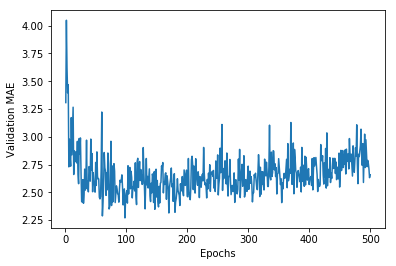

In [117]:
plt.plot(range(1,num_epochs + 1),average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

## Plotting the validation Scores, excluding the first 10 data points

In [118]:
def smooth_curve(points,factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append((previous*factor) + (point* (1-factor)))
        else:
            smoothed_points.append(point)
    return smoothed_points

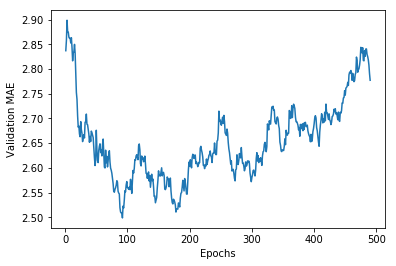

In [119]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()